In [1]:
"""
- Data length is not the multiple of the sequence length? (NO WIRELINE SEGMENTATION ON FACIES!!)

- Data with outlier removed
- CORRECTION TO NEW DATA! (Containing 'Train' and 'Validation' marker)
- DTS is included in the facies prediction
- Facies prediction data is not normalized!
"""

"\n- Data length is not the multiple of the sequence length? (NO WIRELINE SEGMENTATION ON FACIES!!)\n\n- Data with outlier removed\n- CORRECTION TO NEW DATA! (Containing 'Train' and 'Validation' marker)\n- DTS is included in the facies prediction\n- Facies prediction data is not normalized!\n"

In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import BertConfig, BertForMaskedLM
from tqdm import tqdm
import time
from pytorch_msssim import ssim
import sys
from radam import RAdam
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

# Clone from https://github.com/Bjarten/early-stopping-pytorch
sys.path.append('/home/randycm/Documents/Research/Transformers/source/pytorchtools/') # Append path to EarlyStopping here
from pytorchtools import EarlyStopping

from watt.modules import *
from watt.utils import *
from watt.dataset import *

# Setup

## Load data

In [3]:
class WirelineDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    def __getitem__(self, idx):

        well = np.unique(self.data.WELL.values[idx*self.seq_len:(idx+1)*self.seq_len])[0]
        data = self.data.drop(columns=['DTS', 'Type']).values[idx*self.seq_len:(idx+1)*self.seq_len]
        label = self.data['DTS'].values[idx*self.seq_len:(idx+1)*self.seq_len].reshape(-1,1)

        wells = {'well': well, 'data': data, 'label':label}

        return wells
    def __len__(self):
        return int(len(self.data)/self.seq_len)

In [4]:
train_dataloader = torch.load('../data/train_dataset_128.pth')
valid_dataloader = torch.load('../data/valid_dataset_128.pth')

# train_X, train_y = train_dataloader.dataset.tensors
# valid_X, valid_y = valid_dataloader.dataset.tensors

## Initialize BERT config

In [5]:
config = BertConfig()

# Model Parameter
config.hidden_size = 8
config.num_hidden_layers = 4
config.num_attention_heads = 4
config.num_hidden_ffn = 4

config.vocab_size = 9
config.intermediate_size = config.hidden_size*config.num_hidden_ffn
config.initializer_range = .00005
config.max_length = 128
config.max_position_embeddings = config.max_length
config.position_embedding_type = 'sincos'
config.input_type = 'trace'
config.embedding_type = 'none'
config.type_vocab_size = 2
config.output_hidden_states = True
config.output_attentions = True
config.output_scores = True
# Toggle Pre-LN BERT
config.pre_ln = True # True, False

# Training Parameter
config.loss_fn = 'l2' # 'l2', 'ssiml1'
config.loss_pos = 'masked' # 'masked', 'all'
config.optim = 'radam' # 'adam', 'radam'
config.lr = 5e-4
config.epoch = 1000
config.warmup = "none" if config.pre_ln else 0
config.patience = 20
config.batch_size = 16
# config.parent_dir = './8_4_4_128_nooutlier/'
config.pretrain_dir = './test_run/pretrain/'
config.finetune_dir = './test_run/finetune/'
config.mask_procedure = "outside"

## Create the dataset

In [6]:
def reshape_data(data, seq_len, key):
    n_well = len(key)
    reshaped = np.array(data.data[key][:int(len(data)*seq_len)])
    reshaped = reshaped.reshape(len(data), seq_len, n_well)
    reshaped = torch.from_numpy(reshaped)
    
    return reshaped

def norm_data(data):
    ns, seq_len, n_well = data.size()
    data_norm = data.reshape(-1, n_well)
    max_val = data_norm.max(dim=0).values
    data_norm = data_norm / max_val.unsqueeze(0).repeat(ns * seq_len, 1)
    data_norm = data_norm.reshape(ns, seq_len, n_well)
    
    return data_norm, max_val

In [7]:
train_X = reshape_data(train_dataloader, 128, key=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI',
                                                   'PEF', 'DTC'])
valid_X = reshape_data(valid_dataloader, 128, key=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI',
                                                   'PEF', 'DTC'])

# train_X, max_val_train = norm_data(train_X)
# valid_X, max_val_valid = norm_data(valid_X)

train_y = reshape_data(train_dataloader, 128, key=['DTS'])
valid_y = reshape_data(valid_dataloader, 128, key=['DTS'])

# train_y, max_val_train2 = norm_data(train_y)
# valid_y, max_val_valid2 = norm_data(valid_y)

In [8]:
train_data, valid_data = {}, {}

train_data['input'], valid_data['input'] = train_X.clone(), valid_X.clone()
train_data['label'], valid_data['label'] = train_X.clone(), valid_X.clone()

In [9]:
# Create the [mask] token
seed = 123
torch.manual_seed(seed)
mask_token = torch.randn(1, 1, train_data['input'].shape[-1])
# mask_token = -1 + (2 * (mask_token - torch.min(mask_token)) / (torch.max(mask_token) - torch.min(mask_token)))
mask_token = mask_token / torch.max(mask_token)

# Mask data
def mask_all(data, mask_proportion=.15):
    seq_len = data.shape[1]
    mask_label = torch.zeros(data.shape[0], seq_len)
    for i in range(data.shape[0]):
        muted_idx = torch.randperm(seq_len)[:int(np.floor(seq_len * mask_proportion))]
        for j in muted_idx:
            prob = torch.rand(1)
            if prob < 0.8:
                data[i, j, :] = mask_token
            elif prob >= 0.8 and prob < 0.9:
                switch_idx = torch.where(torch.arange(seq_len) != j)[0][torch.randint(high=seq_len-1, size=(1,))]
                data[i, j, :] = data[i, switch_idx, :].squeeze(-1)
            else:
                data[i, j, :] = data[i, j, :]

        mask_label[i, muted_idx] = 1
            
    return data, mask_label

for data in train_data, valid_data:
    data['input'], data['mask_label'] = mask_all(data['input'], mask_proportion=.15)

In [10]:
# Wrap in PyTorch dataset
class WirelineDataset2(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        return {key: val[idx].clone().detach() for key, val in self.data.items()}
    def __len__(self):
        return len(self.data['input'])
    
train_data = WirelineDataset2(train_data)
valid_data = WirelineDataset2(valid_data)

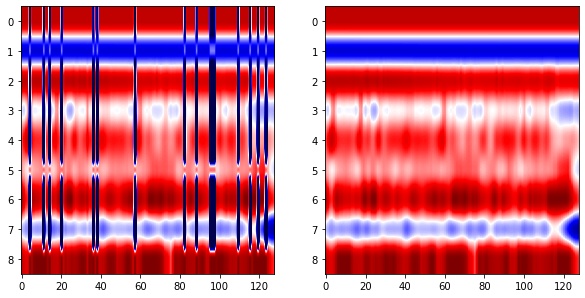

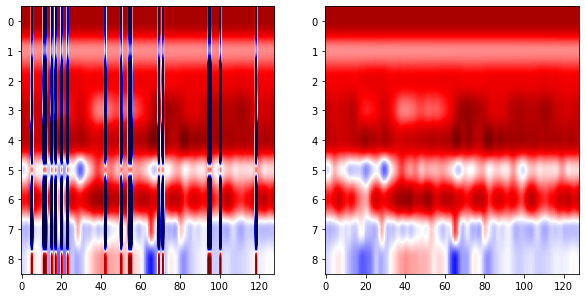

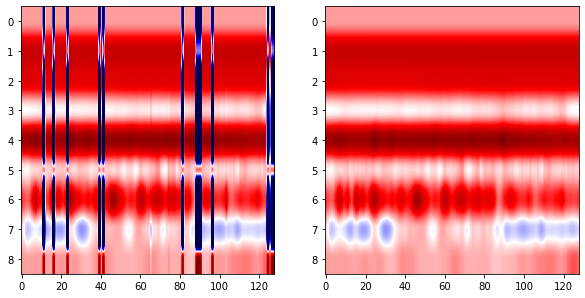

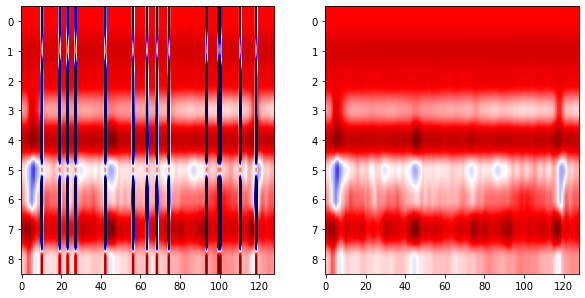

In [11]:
# Wrap in dataloader
batch_size = config.batch_size

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

for i, X in enumerate(train_dataloader):
    if i == 0:
#         ref = torch.arange(1, 2 * X['input'].shape[-1], 2).unsqueeze(0).repeat(X['input'].shape[1], 1)
#         X['input'] = ref + X['input']
#         X['label'] = ref + X['label']
        for j in range(4):
#             for k in range(X['input'].shape)
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
#             ax[0].plot(X['input'][j, :, :])
#             ax[1].plot(X['label'][j, :, :])
            ax[0].imshow(X['input'][j, :, :].swapaxes(0, 1), aspect=15, vmin=0, vmax=1, cmap='seismic')
            ax[1].imshow(X['label'][j, :, :].swapaxes(0, 1), aspect=15, vmin=0, vmax=1, cmap='seismic')

## Initialize BERT model

In [12]:
transformers.models.bert.modeling_bert.BertEmbeddings = BertEmbeddings3
transformers.models.bert.modeling_bert.BertOnlyMLMHead = BertOnlyMLMHead

In [13]:
if config.pre_ln:
    transformers.models.bert.modeling_bert.BertSelfOutput = PreLNBertSelfOutput
    transformers.models.bert.modeling_bert.BertAttention = PreLNBertAttention
    transformers.models.bert.modeling_bert.BertIntermediate = PreLNBertIntermediate
    transformers.models.bert.modeling_bert.BertOutput = PreLNBertOutput

else:
    transformers.models.bert.modeling_bert.BertSelfOutput = BertSelfOutput
    transformers.models.bert.modeling_bert.BertAttention = BertAttention
    transformers.models.bert.modeling_bert.BertIntermediate = BertIntermediate
    transformers.models.bert.modeling_bert.BertOutput = BertOutput

In [14]:
model = BertForMaskedLM(config)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings3(
      (word_embeddings): Linear(in_features=9, out_features=8, bias=True)
      (position_embeddings): Embedding(128, 8)
      (LayerNorm): LayerNorm((8,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((8,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=8, out_features=8, bias=True)
              (key): Linear(in_features=8, out_features=8, bias=True)
              (value): Linear(in_features=8, out_features=8, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_features=8, out_features=8, bias=True)
              (dropout): Dropout(p=0.1, inplac

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


# Pre-training

In [16]:
config.parent_dir = config.pretrain_dir

In [17]:
# Optimizer
if config.optim == 'adam':
    optim = torch.optim.Adam(model.parameters(), lr=config.lr)
elif config.optim == 'radam':
    optim = RAdam(model.parameters(), lr=config.lr)

# Loss
if config.loss_fn == 'l2':
    loss_fn = nn.MSELoss(reduction='mean')
elif config.loss_fn in ['l1', 'ssiml1']:
    loss_fn = nn.L1Loss()

# Number of epochs
epochs = config.epoch

In [18]:
def run_training(epochs):
    total_time = time.time()
    avg_train_loss = []
    avg_valid_loss = []
    eps = []
    time_per_epoch = []
    # mask_proportion = [0, .05, .1, .15]
    checkpoint = os.path.join(config.parent_dir, str(os.getpid())+"checkpoint.pt")
    early_stopping = EarlyStopping(patience=config.patience, verbose=True, path=checkpoint)

    for epoch in range(epochs):
        epoch_time = time.time()
        model.train()
        # setup loop with TQDM and dataloader
        loop_train = tqdm(train_dataloader, leave=True)
        losses_train = 0
        for i, batch in enumerate(loop_train):
            # initialize calculated gradients (from prev step)
            optim.zero_grad()

            # pull all tensor batches required for training

            # Mask outside loop
            if config.mask_procedure == "outside":
                inputs_embeds = batch['input'].to(device)
                mask_label = batch['mask_label'].to(device)
                labels = batch['label'].to(device)
                
            # Mask inside loop
            elif config.mask_procedure == "inside":
                inputs_embeds, mask_label = mask_input(batch['input'], mask_proportion=config.mask_proportion)
                inputs_embeds = inputs_embeds.to(device)
                mask_label = mask_label.to(device)
                labels = batch['label'].to(device)

            # process

            outputs = model(inputs_embeds=inputs_embeds.float())

            if config.loss_pos == "masked":
                select_matrix = mask_label.unsqueeze(-1).expand(-1, -1, config.vocab_size)
            elif config.loss_pos == "all":
                select_matrix = 1

            if config.loss_fn in ["l2", "l1"]:
                loss = loss_fn(outputs.logits * select_matrix, labels.float() * select_matrix)
            elif config.loss_fn == "ssiml1":
                masked_output = outputs.logits * select_matrix
                masked_output = masked_output.unsqueeze(-1).repeat(1, 1, 1, 3).permute(0, 3, 1, 2)
                masked_label = labels * select_matrix
                masked_label = masked_label.unsqueeze(-1).repeat(1, 1, 1, 3).permute(0, 3, 1, 2)
                loss1 = 1 - ssim(masked_output.unsqueeze(-1), masked_label.unsqueeze(-1))
                loss2 = loss_fn(masked_output, masked_label)
                loss = loss1 + loss2

            outputs.loss = loss
            outputs.loss.backward()

            # update parameters
            optim.step()            

            losses_train += loss.item()

            loop_train.set_description(f'Epoch {epoch}')
            loop_train.set_postfix(loss=loss.item())

            eps.append(optim.param_groups[0]["lr"])

        loop_valid = tqdm(valid_dataloader, leave=True)
        losses_valid = 0
        with torch.no_grad():
            for i, batch in enumerate(loop_valid):
                # pull all tensor batches required for training

                # Mask outside loop
                if config.mask_procedure == "outside":
                    inputs_embeds = batch['input'].to(device)
                    mask_label = batch['mask_label'].to(device)
                    labels = batch['label'].to(device)

                # Mask inside loop
                elif config.mask_procedure == "inside":
                    inputs_embeds, mask_label = mask_input(batch['input'], mask_proportion=config.mask_proportion)
                    inputs_embeds = inputs_embeds.to(device)
                    mask_label = mask_label.to(device)
                    labels = batch['label'].to(device)

                # process

                outputs = model(inputs_embeds=inputs_embeds.float())

                if config.loss_pos == "masked":
                    select_matrix = mask_label.unsqueeze(-1).expand(-1, -1, config.vocab_size)
                elif config.loss_pos == "all":
                    select_matrix = 1

                if config.loss_fn in ["l2", "l1"]:
                    loss = loss_fn(outputs.logits * select_matrix, labels.float() * select_matrix)
                elif config.loss_fn == "ssiml1":
                    masked_output = outputs.logits * select_matrix
                    masked_output = masked_output.unsqueeze(-1).repeat(1, 1, 1, 3).permute(0, 3, 1, 2)
                    masked_label = labels * select_matrix
                    masked_label = masked_label.unsqueeze(-1).repeat(1, 1, 1, 3).permute(0, 3, 1, 2)
                    loss1 = 1 - ssim(masked_output.unsqueeze(-1), masked_label.unsqueeze(-1))
                    loss2 = loss_fn(masked_output, masked_label)
                    loss = loss1 + loss2

                losses_valid += loss.item()

                loop_valid.set_description(f'Validation {epoch}')
                loop_valid.set_postfix(loss=loss.item())

        avg_train_loss.append(losses_train / len(train_dataloader))
        avg_valid_loss.append(losses_valid / len(valid_dataloader))
        print("Last learning rate: {}".format(eps[-1]))
        print("Epoch time: {:.2f} s".format(time.time() - epoch_time))
        time_per_epoch.append(time.time() - epoch_time)
        print("Total time elapsed: {:.2f} s".format(time.time() - total_time))
        print("---------------------------------------")
        
        ax1.cla()
        ax1.plot(np.arange(1, epoch+2), avg_train_loss,'b', label='Training Loss')
        ax1.plot(np.arange(1, epoch+2), avg_valid_loss, 'orange', label='Validation Loss')
        ax1.legend()
        ax1.set_title("Loss Curve")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Avg Loss")
        f1.canvas.draw()
        
        ax2.cla()
        ax2.plot(np.arange(1, len(train_dataloader)*(epoch+1)+1), eps,'b')
        ax2.set_title("Learning Rate Curve")
        ax2.set_xlabel("Steps")
        ax2.set_ylabel("lr")
        f2.canvas.draw()

        early_stopping(avg_valid_loss[-1], model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load(checkpoint))

    return model, avg_train_loss, avg_valid_loss, eps, time_per_epoch

<IPython.core.display.Javascript object>


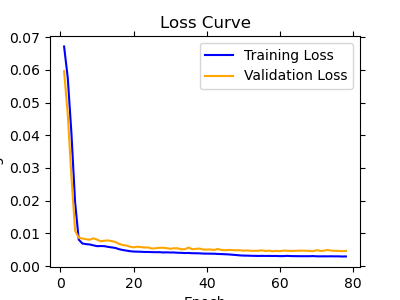

In [19]:
%matplotlib notebook

plt.ion()
f1, ax1 = plt.subplots(figsize=(4, 3))

<IPython.core.display.Javascript object>


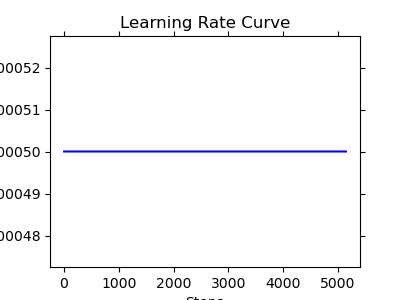

In [20]:
f2, ax2 = plt.subplots(figsize=(4, 3))

In [21]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

model, avg_train_loss, avg_valid_loss, eps, time_per_epoch = run_training(epochs)

%matplotlib inline
plt.ioff()

  0%|                                                    | 0/66 [00:00<?, ?it/s]/home/randycm/anaconda3/envs/transformers-2/lib/python3.8/site-packages/radam/radam.py:58: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
Validation 0: 100%|███████████████| 22/22 [00:00<00:00, 158.47it/s, loss=0.0738]


Last learning rate: 0.0005
Epoch time: 2.40 s
Total time elapsed: 2.40 s
---------------------------------------
Validation loss decreased (inf --> 0.059603).  Saving model ...


Validation 1: 100%|███████████████| 22/22 [00:00<00:00, 174.87it/s, loss=0.0457]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 4.64 s
---------------------------------------
Validation loss decreased (0.059603 --> 0.046414).  Saving model ...


Validation 2: 100%|████████████████| 22/22 [00:00<00:00, 150.36it/s, loss=0.022]


Last learning rate: 0.0005
Epoch time: 2.19 s
Total time elapsed: 6.97 s
---------------------------------------
Validation loss decreased (0.046414 --> 0.027391).  Saving model ...


Validation 3: 100%|███████████████| 22/22 [00:00<00:00, 168.05it/s, loss=0.0113]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 9.29 s
---------------------------------------
Validation loss decreased (0.027391 --> 0.010843).  Saving model ...


Validation 4: 100%|███████████████| 22/22 [00:00<00:00, 171.85it/s, loss=0.0118]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 11.55 s
---------------------------------------
Validation loss decreased (0.010843 --> 0.008652).  Saving model ...


Validation 5: 100%|███████████████| 22/22 [00:00<00:00, 170.69it/s, loss=0.0112]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 13.79 s
---------------------------------------
Validation loss decreased (0.008652 --> 0.008418).  Saving model ...


Validation 6: 100%|██████████████| 22/22 [00:00<00:00, 149.50it/s, loss=0.00792]


Last learning rate: 0.0005
Epoch time: 2.16 s
Total time elapsed: 16.06 s
---------------------------------------
Validation loss decreased (0.008418 --> 0.008205).  Saving model ...


Validation 7: 100%|██████████████| 22/22 [00:00<00:00, 166.97it/s, loss=0.00407]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 18.29 s
---------------------------------------
Validation loss decreased (0.008205 --> 0.008045).  Saving model ...


Validation 8: 100%|███████████████| 22/22 [00:00<00:00, 167.93it/s, loss=0.0153]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 20.54 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 9: 100%|███████████████| 22/22 [00:00<00:00, 166.69it/s, loss=0.0101]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 22.78 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 10: 100%|██████████████| 22/22 [00:00<00:00, 172.65it/s, loss=0.0035]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 25.02 s
---------------------------------------
Validation loss decreased (0.008045 --> 0.007573).  Saving model ...


Validation 11: 100%|█████████████| 22/22 [00:00<00:00, 172.31it/s, loss=0.00765]


Last learning rate: 0.0005
Epoch time: 2.11 s
Total time elapsed: 27.24 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 12: 100%|██████████████| 22/22 [00:00<00:00, 167.06it/s, loss=0.0103]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 29.47 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 13: 100%|█████████████| 22/22 [00:00<00:00, 170.66it/s, loss=0.00761]


Last learning rate: 0.0005
Epoch time: 2.18 s
Total time elapsed: 31.76 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 14: 100%|█████████████| 22/22 [00:00<00:00, 172.40it/s, loss=0.00963]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 33.99 s
---------------------------------------
Validation loss decreased (0.007573 --> 0.007351).  Saving model ...


Validation 15: 100%|█████████████| 22/22 [00:00<00:00, 170.81it/s, loss=0.00762]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 36.23 s
---------------------------------------
Validation loss decreased (0.007351 --> 0.006810).  Saving model ...


Validation 16: 100%|█████████████| 22/22 [00:00<00:00, 171.40it/s, loss=0.00547]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 38.46 s
---------------------------------------
Validation loss decreased (0.006810 --> 0.006429).  Saving model ...


Validation 17: 100%|█████████████| 22/22 [00:00<00:00, 166.63it/s, loss=0.00731]


Last learning rate: 0.0005
Epoch time: 2.11 s
Total time elapsed: 40.68 s
---------------------------------------
Validation loss decreased (0.006429 --> 0.006295).  Saving model ...


Validation 18: 100%|█████████████| 22/22 [00:00<00:00, 166.81it/s, loss=0.00415]


Last learning rate: 0.0005
Epoch time: 2.10 s
Total time elapsed: 42.90 s
---------------------------------------
Validation loss decreased (0.006295 --> 0.005930).  Saving model ...


Validation 19: 100%|██████████████| 22/22 [00:00<00:00, 166.94it/s, loss=0.0037]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 45.22 s
---------------------------------------
Validation loss decreased (0.005930 --> 0.005705).  Saving model ...


Validation 20: 100%|██████████████| 22/22 [00:00<00:00, 170.40it/s, loss=0.0102]


Last learning rate: 0.0005
Epoch time: 2.11 s
Total time elapsed: 47.44 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 21: 100%|█████████████| 22/22 [00:00<00:00, 170.26it/s, loss=0.00741]


Last learning rate: 0.0005
Epoch time: 2.11 s
Total time elapsed: 49.66 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 22: 100%|█████████████| 22/22 [00:00<00:00, 167.62it/s, loss=0.00553]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 51.89 s
---------------------------------------
Validation loss decreased (0.005705 --> 0.005672).  Saving model ...


Validation 23: 100%|█████████████| 22/22 [00:00<00:00, 157.31it/s, loss=0.00783]


Last learning rate: 0.0005
Epoch time: 2.18 s
Total time elapsed: 54.18 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 24: 100%|█████████████| 22/22 [00:00<00:00, 156.56it/s, loss=0.00274]


Last learning rate: 0.0005
Epoch time: 2.19 s
Total time elapsed: 56.48 s
---------------------------------------
Validation loss decreased (0.005672 --> 0.005339).  Saving model ...


Validation 25: 100%|██████████████| 22/22 [00:00<00:00, 138.25it/s, loss=0.0041]


Last learning rate: 0.0005
Epoch time: 2.17 s
Total time elapsed: 58.77 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 26: 100%|██████████████| 22/22 [00:00<00:00, 169.18it/s, loss=0.0062]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 61.01 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 27: 100%|█████████████| 22/22 [00:00<00:00, 171.17it/s, loss=0.00917]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 63.27 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 28: 100%|█████████████| 22/22 [00:00<00:00, 171.66it/s, loss=0.00739]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 65.50 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 29: 100%|█████████████| 22/22 [00:00<00:00, 170.15it/s, loss=0.00344]


Last learning rate: 0.0005
Epoch time: 2.16 s
Total time elapsed: 67.77 s
---------------------------------------
Validation loss decreased (0.005339 --> 0.005272).  Saving model ...


Validation 30: 100%|█████████████| 22/22 [00:00<00:00, 172.47it/s, loss=0.00881]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 70.02 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 31: 100%|█████████████| 22/22 [00:00<00:00, 170.93it/s, loss=0.00697]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 72.27 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 32: 100%|█████████████| 22/22 [00:00<00:00, 172.49it/s, loss=0.00503]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 74.51 s
---------------------------------------
Validation loss decreased (0.005272 --> 0.005138).  Saving model ...


Validation 33: 100%|█████████████| 22/22 [00:00<00:00, 167.75it/s, loss=0.00339]


Last learning rate: 0.0005
Epoch time: 2.16 s
Total time elapsed: 76.79 s
---------------------------------------
Validation loss decreased (0.005138 --> 0.005126).  Saving model ...


Validation 34: 100%|██████████████| 22/22 [00:00<00:00, 169.61it/s, loss=0.0171]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 79.03 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 35: 100%|█████████████| 22/22 [00:00<00:00, 170.12it/s, loss=0.00723]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 81.35 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 36: 100%|█████████████| 22/22 [00:00<00:00, 174.07it/s, loss=0.00805]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 83.58 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 37: 100%|██████████████| 22/22 [00:00<00:00, 170.08it/s, loss=0.0101]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 85.81 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 38: 100%|█████████████| 22/22 [00:00<00:00, 171.41it/s, loss=0.00457]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 88.04 s
---------------------------------------
Validation loss decreased (0.005126 --> 0.005050).  Saving model ...


Validation 39: 100%|█████████████| 22/22 [00:00<00:00, 166.16it/s, loss=0.00513]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 90.28 s
---------------------------------------
Validation loss decreased (0.005050 --> 0.005035).  Saving model ...


Validation 40: 100%|█████████████| 22/22 [00:00<00:00, 170.01it/s, loss=0.00644]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 92.51 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 41: 100%|█████████████| 22/22 [00:00<00:00, 169.33it/s, loss=0.00345]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 94.74 s
---------------------------------------
Validation loss decreased (0.005035 --> 0.004941).  Saving model ...


Validation 42: 100%|██████████████| 22/22 [00:00<00:00, 159.61it/s, loss=0.0102]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 97.00 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 43: 100%|█████████████| 22/22 [00:00<00:00, 144.75it/s, loss=0.00453]


Last learning rate: 0.0005
Epoch time: 2.17 s
Total time elapsed: 99.28 s
---------------------------------------
Validation loss decreased (0.004941 --> 0.004917).  Saving model ...


Validation 44: 100%|█████████████| 22/22 [00:00<00:00, 169.45it/s, loss=0.00292]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 101.52 s
---------------------------------------
Validation loss decreased (0.004917 --> 0.004839).  Saving model ...


Validation 45: 100%|█████████████| 22/22 [00:00<00:00, 169.81it/s, loss=0.00492]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 103.76 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 46: 100%|█████████████| 22/22 [00:00<00:00, 169.08it/s, loss=0.00466]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 106.01 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 47: 100%|█████████████| 22/22 [00:00<00:00, 170.30it/s, loss=0.00438]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 108.25 s
---------------------------------------
Validation loss decreased (0.004839 --> 0.004810).  Saving model ...


Validation 48: 100%|██████████████| 22/22 [00:00<00:00, 168.64it/s, loss=0.0046]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 110.50 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 49: 100%|█████████████| 22/22 [00:00<00:00, 173.14it/s, loss=0.00305]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 112.73 s
---------------------------------------
Validation loss decreased (0.004810 --> 0.004683).  Saving model ...


Validation 50: 100%|█████████████| 22/22 [00:00<00:00, 164.97it/s, loss=0.00354]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 114.99 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 51: 100%|█████████████| 22/22 [00:00<00:00, 166.41it/s, loss=0.00287]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 117.23 s
---------------------------------------
Validation loss decreased (0.004683 --> 0.004653).  Saving model ...


Validation 52: 100%|█████████████| 22/22 [00:00<00:00, 171.78it/s, loss=0.00414]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 119.54 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 53: 100%|█████████████| 22/22 [00:00<00:00, 164.97it/s, loss=0.00463]


Last learning rate: 0.0005
Epoch time: 2.16 s
Total time elapsed: 121.81 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 54: 100%|█████████████| 22/22 [00:00<00:00, 145.24it/s, loss=0.00693]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 124.06 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 55: 100%|█████████████| 22/22 [00:00<00:00, 171.75it/s, loss=0.00103]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 126.30 s
---------------------------------------
Validation loss decreased (0.004653 --> 0.004592).  Saving model ...


Validation 56: 100%|█████████████| 22/22 [00:00<00:00, 171.36it/s, loss=0.00237]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 128.54 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 57: 100%|████████████| 22/22 [00:00<00:00, 166.19it/s, loss=0.000865]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 130.78 s
---------------------------------------
Validation loss decreased (0.004592 --> 0.004521).  Saving model ...


Validation 58: 100%|█████████████| 22/22 [00:00<00:00, 144.78it/s, loss=0.00473]


Last learning rate: 0.0005
Epoch time: 2.16 s
Total time elapsed: 133.07 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 59: 100%|█████████████| 22/22 [00:00<00:00, 137.61it/s, loss=0.00115]


Last learning rate: 0.0005
Epoch time: 2.20 s
Total time elapsed: 135.38 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 60: 100%|█████████████| 22/22 [00:00<00:00, 154.75it/s, loss=0.00475]


Last learning rate: 0.0005
Epoch time: 2.17 s
Total time elapsed: 137.67 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 61: 100%|█████████████| 22/22 [00:00<00:00, 157.30it/s, loss=0.00454]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 139.94 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 62: 100%|█████████████| 22/22 [00:00<00:00, 153.15it/s, loss=0.00343]


Last learning rate: 0.0005
Epoch time: 2.16 s
Total time elapsed: 142.22 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 63: 100%|█████████████| 22/22 [00:00<00:00, 170.92it/s, loss=0.00417]


Last learning rate: 0.0005
Epoch time: 2.17 s
Total time elapsed: 144.51 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 64: 100%|█████████████| 22/22 [00:00<00:00, 155.61it/s, loss=0.00415]


Last learning rate: 0.0005
Epoch time: 2.17 s
Total time elapsed: 146.79 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 65: 100%|█████████████| 22/22 [00:00<00:00, 154.45it/s, loss=0.00686]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 149.05 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 66: 100%|█████████████| 22/22 [00:00<00:00, 155.88it/s, loss=0.00444]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 151.30 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 67: 100%|█████████████| 22/22 [00:00<00:00, 156.72it/s, loss=0.00391]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 153.63 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 68: 100%|█████████████| 22/22 [00:00<00:00, 173.49it/s, loss=0.00232]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 155.88 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 69: 100%|█████████████| 22/22 [00:00<00:00, 169.75it/s, loss=0.00963]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 158.12 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 70: 100%|█████████████| 22/22 [00:00<00:00, 170.99it/s, loss=0.00457]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 160.36 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 71: 100%|█████████████| 22/22 [00:00<00:00, 172.28it/s, loss=0.00526]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 162.59 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 72: 100%|██████████████| 22/22 [00:00<00:00, 172.07it/s, loss=0.0106]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 164.83 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 73: 100%|█████████████| 22/22 [00:00<00:00, 167.98it/s, loss=0.00598]


Last learning rate: 0.0005
Epoch time: 2.23 s
Total time elapsed: 167.16 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 74: 100%|█████████████| 22/22 [00:00<00:00, 169.21it/s, loss=0.00413]


Last learning rate: 0.0005
Epoch time: 2.46 s
Total time elapsed: 169.73 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 75: 100%|██████████████| 22/22 [00:00<00:00, 167.49it/s, loss=0.0034]


Last learning rate: 0.0005
Epoch time: 2.51 s
Total time elapsed: 172.35 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 76: 100%|█████████████| 22/22 [00:00<00:00, 147.00it/s, loss=0.00401]


Last learning rate: 0.0005
Epoch time: 2.51 s
Total time elapsed: 174.97 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 77: 100%|█████████████| 22/22 [00:00<00:00, 157.00it/s, loss=0.00272]


Last learning rate: 0.0005
Epoch time: 2.53 s
Total time elapsed: 177.61 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


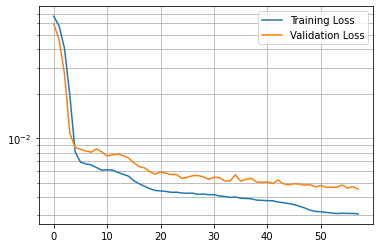

In [22]:
plt.semilogy(avg_train_loss[:-config.patience], label='Training Loss')
plt.semilogy(avg_valid_loss[:-config.patience], label='Validation Loss')
plt.grid(which='both')
plt.legend()

## Plot result

/tmp/ipykernel_5010/247104073.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 0].set_yticklabels(yticks)


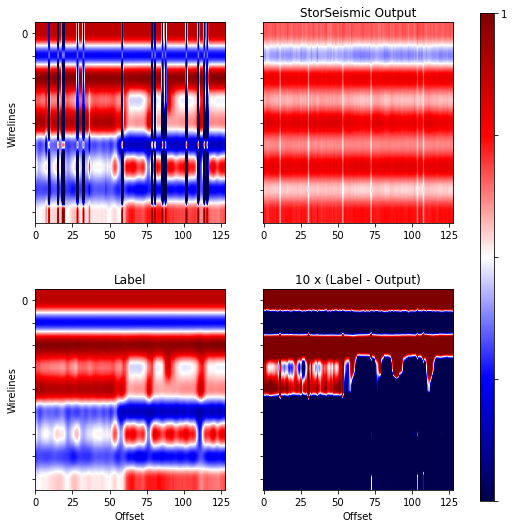

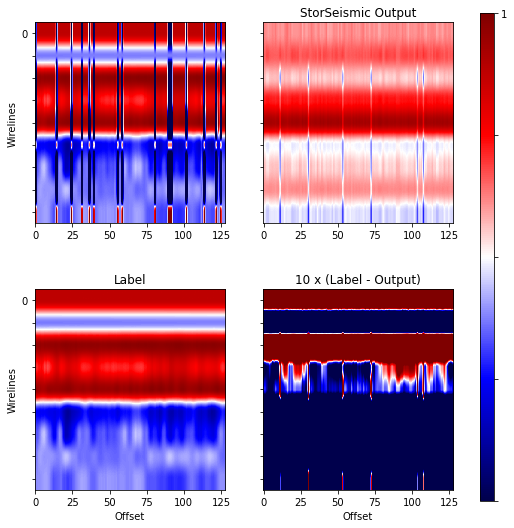

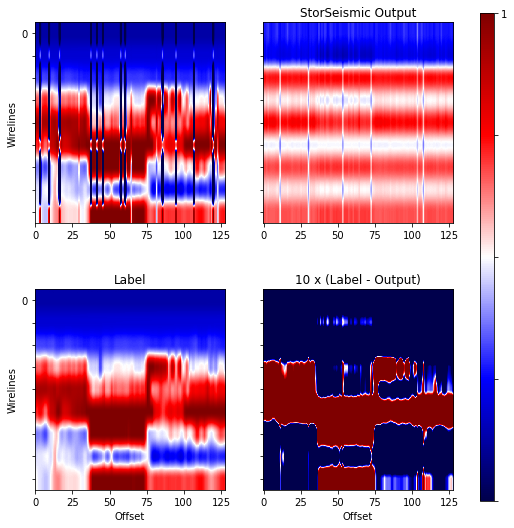

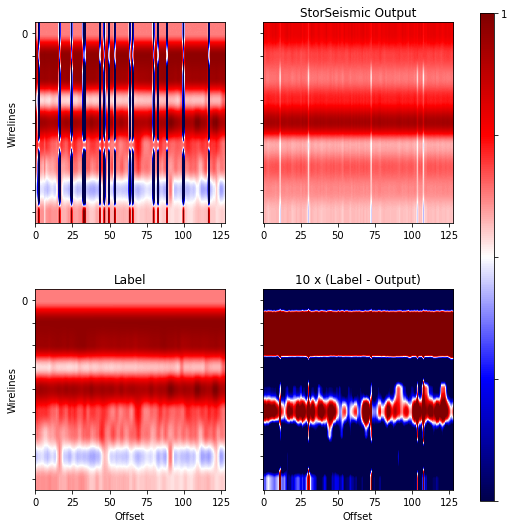

In [23]:
model.eval()

idx = torch.randint(high=len(valid_data), size=(4,))
inputs_embeds = valid_data.data['input'][idx]
labels = valid_data.data['label'][idx]
mask_label = valid_data.data['mask_label'][idx].unsqueeze(-1).expand(-1, -1, config.vocab_size)
with torch.no_grad():
    sample_output = model(inputs_embeds=inputs_embeds.to(device).float())
# i = 1

for X, y, z, mask in zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels.cpu(), mask_label.cpu()):
    f, ax = plt.subplots(2, 2, figsize=(7.5, 9), sharey=True, sharex=False)
    ax[0, 0].imshow(X.detach().swapaxes(0, 1), aspect=15, vmin=0, vmax=1, cmap='seismic')
#     ax[0, 0].set_title("Input ({})".format("Field" if index < 0 else "Synthetic"))
    yticks = [0]+list(np.arange(0, 2*config.vocab_size, 2*50))
    ax[0, 0].set_yticklabels(yticks)
    ax[0, 0].set_ylabel("Wirelines")
#     output = torch.where(mask == 0, X.float(), y)
    output = y
    ax[0, 1].imshow(output.detach().swapaxes(0, 1), aspect=15, vmin=0, vmax=1, cmap='seismic')
    ax[0, 1].set_title("StorSeismic Output")
    ax[1, 0].imshow(z.detach().swapaxes(0, 1), aspect=15, vmin=0, vmax=1, cmap='seismic')
    ax[1, 0].set_title("Label")
    ax[1, 0].set_xlabel("Offset")
    ax[1, 0].set_ylabel("Wirelines")
    diff = 10 * (z - output)
    im4 = ax[1, 1].imshow(diff.detach().swapaxes(0, 1), aspect=15, vmin=0, vmax=1, cmap='seismic')
    ax[1, 1].set_title("10 x (Label - Output)")
    ax[1, 1].set_xlabel("Offset")
    cbar_ax = f.add_axes([0.95, 0.125, 0.025, 0.7525])
    cbar = f.colorbar(im4, cax=cbar_ax)
    cbar.set_ticks(np.arange(-1, 1.25, .25))
    cbar.set_ticklabels([-1, "", "", "", "", "", "", "", 1])

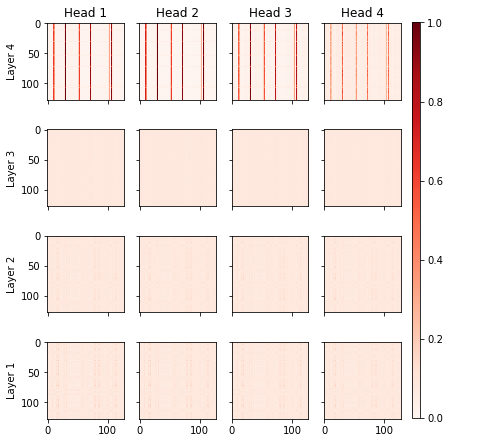

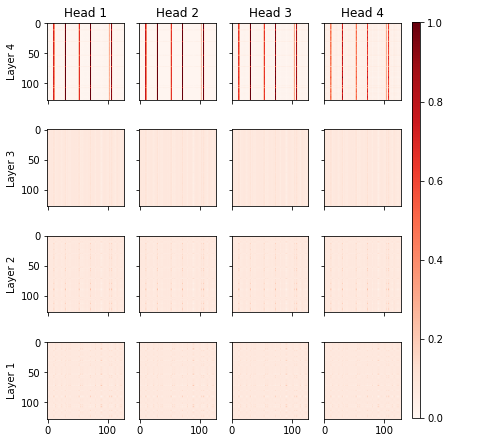

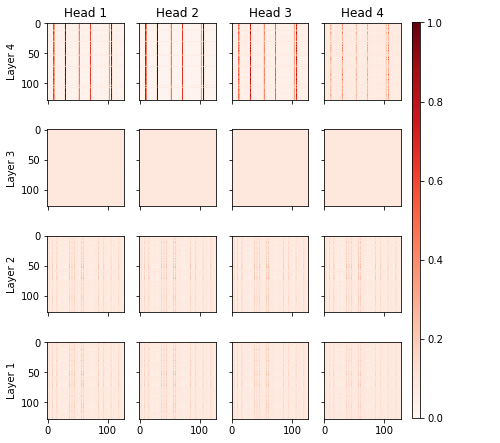

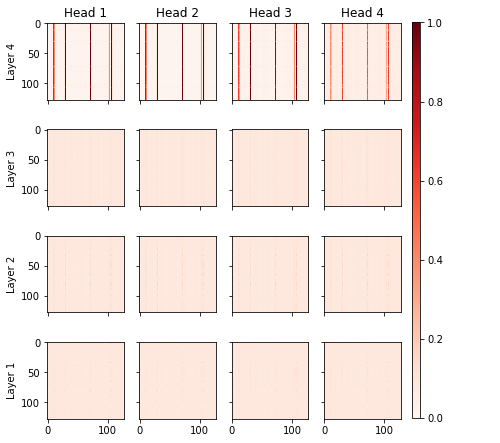

In [24]:
n_layer = config.num_hidden_layers
n_head = config.num_attention_heads

for X in range(len(idx)):

    f, ax = plt.subplots(n_layer, n_head+1, figsize=(7.5, 7.5), sharey=True, sharex=True)
    k = n_layer-1
    for i in range(n_layer):
        l = n_head-1
        for j in range(n_head):
            im = ax[i, j].imshow(10 * sample_output.attentions[k][X, l].detach().cpu(), aspect='equal', vmin=0, vmax=1, cmap='Reds')
            ax[0, j].set_title("Head {}".format(j + 1), fontweight='regular')  
            l += -1
#             ax[i, j].xaxis.set_minor_locator(AutoMinorLocator(10))
#             ax[i, j].yaxis.set_minor_locator(AutoMinorLocator(10))
        ax[i, 0].set_ylabel("Layer {}".format(k + 1))
        ax[i, n_head].axis('off')
        k += -1 
    f.subplots_adjust(right=0.95)
    cbar_ax = f.add_axes([0.8, 0.1375, 0.015, 0.7325])
    f.colorbar(im, cax=cbar_ax)
#     f.suptitle("Attention Maps", y=0.95, fontsize='x-large')
    plt.show(f)

## Evaluate results

In [25]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
input_train = []
pred_train = []
loop_train = tqdm(train_dataloader, leave=True)
model.eval()

with torch.no_grad():
    for i, batch in enumerate(loop_train):
        # pull all tensor batches required for training

        # Mask outside loop
        inputs_embeds = batch['input'].float().to(device)
        labels = batch['label'].to(device)

        # process

        outputs = model(inputs_embeds=inputs_embeds)
        
        for j in range(len(outputs.logits)):
            input_train.append(inputs_embeds.squeeze()[j].cpu().numpy())
            pred_train.append(outputs.logits.squeeze()[j].cpu().numpy())
            
input_train = np.array(input_train)
pred_train = np.array(pred_train)
np.save(os.path.join(config.parent_dir, "input_train.npy"), input_train)
np.save(os.path.join(config.parent_dir, "pred_train.npy"), pred_train)

valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
input_valid = []             
pred_valid = []
loop_valid = tqdm(valid_dataloader, leave=True)
model.eval()

with torch.no_grad():
    for i, batch in enumerate(loop_valid):
        # pull all tensor batches required for training

        # Mask outside loop
        inputs_embeds = batch['input'].float().to(device)
        labels = batch['label'].to(device)

        # process

        outputs = model(inputs_embeds=inputs_embeds)
        
        for j in range(len(outputs.logits)):
            input_valid.append(inputs_embeds.squeeze()[j].cpu().numpy())
            pred_valid.append(outputs.logits.squeeze()[j].cpu().numpy())
            
input_valid = np.array(input_valid)
pred_valid = np.array(pred_valid)
np.save(os.path.join(config.parent_dir, "input_valid.npy"), input_valid)
np.save(os.path.join(config.parent_dir, "pred_valid.npy"), pred_valid)

100%|██████████████████████████████████████████| 66/66 [00:00<00:00, 297.99it/s]
/tmp/ipykernel_5010/4231964073.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_train = np.array(input_train)
/tmp/ipykernel_5010/4231964073.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_train = np.array(pred_train)
100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 302.79it/s]
/tmp/ipykernel_5010/4231964073.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tupl

In [26]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss)
        avg_valid_loss_arr = np.array(avg_valid_loss)
        eps_arr = np.array(eps)
        time_arr = np.array(time_per_epoch)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
        np.save(os.path.join(config.parent_dir, 'eps.npy'), eps_arr)
        np.save(os.path.join(config.parent_dir, 'time.npy'), time_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss)
    avg_valid_loss_arr = np.array(avg_valid_loss)
    eps_arr = np.array(eps)
    time_arr = np.array(time_per_epoch)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
    np.save(os.path.join(config.parent_dir, 'eps.npy'), eps_arr)
    np.save(os.path.join(config.parent_dir, 'time.npy'), time_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./test_run/pretrain/
Saved successfully to ./test_run/pretrain/


# Fine-tuning (DTS Prediction)

In [27]:
config.parent_dir = config.pretrain_dir
model = torch.load(os.path.join(config.parent_dir, "model.pt"))
print("Loaded model from", config.parent_dir)

Loaded model from ./test_run/pretrain/


In [28]:
# Change parent directory
config.parent_dir = os.path.join(config.finetune_dir, "dtspred/")
print(config.parent_dir)

./test_run/finetune/dtspred/


## Create fine-tuning dataset

In [29]:
# train_y = reshape_data(train_y, config.max_length)
# valid_y = reshape_data(valid_y, config.max_length)

In [30]:
train_data2, valid_data2 = {}, {}

train_data2['input'], valid_data2['input'] = train_X.clone(), valid_X.clone()
train_data2['label'], valid_data2['label'] = train_y.clone(), valid_y.clone()

In [31]:
train_data2 = WirelineDataset2(train_data2)
valid_data2 = WirelineDataset2(valid_data2)

In [32]:
train_dataloader2 = DataLoader(train_data2, batch_size=batch_size, shuffle=True)
valid_dataloader2 = DataLoader(valid_data2, batch_size=batch_size, shuffle=True)

## Initialize fine-tuning model

In [33]:
class DTSPredHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = nn.Linear(config.hidden_size, 1)
        self.predictions.decoder = Identity()
#         self.act_fn = nn.Sigmoid()
        
    def forward(self, sequence_output):
#         output = self.act_fn(sequence_output)
        output = self.predictions(sequence_output)
        
        return output

In [34]:
# Replace the prediciton head of the pre-trained model
model.cls = DTSPredHead(config)
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings3(
      (word_embeddings): Linear(in_features=9, out_features=8, bias=True)
      (position_embeddings): Embedding(128, 8)
      (LayerNorm): LayerNorm((8,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((8,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=8, out_features=8, bias=True)
              (key): Linear(in_features=8, out_features=8, bias=True)
              (value): Linear(in_features=8, out_features=8, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_features=8, out_features=8, bias=True)
              (dropout): Dropout(p=0.1, inplac

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


In [36]:
# Optimizer
if config.optim == 'adam':
    optim = torch.optim.Adam(model.parameters(), lr=config.lr)
elif config.optim == 'radam':
    optim = RAdam(model.parameters(), lr=config.lr)

# # Loss
# if config.loss_fn == 'l2':
#     loss_fn = nn.MSELoss(reduction='mean')
# elif config.loss_fn in ['l1', 'ssiml1']:
#     loss_fn = nn.L1Loss()
    
# loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

# Number of epochs
epochs = config.epoch

## Train

In [37]:
def run_training2(epochs):
    total_time = time.time()
    avg_train_loss = []
    avg_valid_loss = []
    eps = []
    time_per_epoch = []
    checkpoint = os.path.join(config.parent_dir, str(os.getpid())+"checkpoint.pt")
    early_stopping = EarlyStopping(patience=config.patience, verbose=True, path=checkpoint)

    for epoch in range(epochs):
        epoch_time = time.time()
        model.train()
        # setup loop with TQDM and dataloader
        loop_train = tqdm(train_dataloader2, leave=True)
        losses_train = 0
        for i, batch in enumerate(loop_train):
            # initialize calculated gradients (from prev step)
            optim.zero_grad()

            # pull all tensor batches required for training

            # Mask outside loop
            inputs_embeds = batch['input'].float().to(device)
            labels = batch['label'].to(device)

            # process

            outputs = model(inputs_embeds=inputs_embeds)
            
            loss = loss_fn(outputs.logits, labels)
            
            outputs.loss = loss
            outputs.loss.backward()

            # update parameters
            optim.step()
            
            losses_train += loss.item()

            loop_train.set_description(f'Epoch {epoch}')
            loop_train.set_postfix(loss=loss.item())

            eps.append(optim.param_groups[0]["lr"])

#         model.eval()
        loop_valid = tqdm(valid_dataloader2, leave=True)
        losses_valid = 0
        with torch.no_grad():
            for i, batch in enumerate(loop_valid):
                # pull all tensor batches required for training

                # Mask outside loop
                inputs_embeds = batch['input'].float().to(device)
                labels = batch['label'].to(device)

                # process

                outputs = model(inputs_embeds=inputs_embeds)
                
                loss = loss_fn(outputs.logits, labels)

                losses_valid += loss.item()

                loop_valid.set_description(f'Validation {epoch}')
                loop_valid.set_postfix(loss=loss.item())

        avg_train_loss.append(losses_train / len(train_dataloader2))
        avg_valid_loss.append(losses_valid / len(valid_dataloader2))
        print("Last learning rate: {}".format(eps[-1]))
        print("Epoch time: {:.2f} s".format(time.time() - epoch_time))
        time_per_epoch.append(time.time() - epoch_time)
        print("Total time elapsed: {:.2f} s".format(time.time() - total_time))
        print("---------------------------------------")

        ax1.cla()
        ax1.plot(np.arange(1, epoch+2), avg_train_loss,'b', label='Training Loss')
        ax1.plot(np.arange(1, epoch+2), avg_valid_loss, 'orange', label='Validation Loss')
        ax1.legend()
        ax1.set_title("Loss Curve")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Avg Loss")
        f1.canvas.draw()
        
        ax2.cla()
        ax2.plot(np.arange(1, len(train_dataloader2)*(epoch+1)+1), eps,'b')
        ax2.set_title("Learning Rate Curve")
        ax2.set_xlabel("Steps")
        ax2.set_ylabel("lr")
        f2.canvas.draw()
        
        early_stopping(avg_valid_loss[-1], model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    model.load_state_dict(torch.load(checkpoint))
    
    return model, avg_train_loss, avg_valid_loss, eps, time_per_epoch

<IPython.core.display.Javascript object>


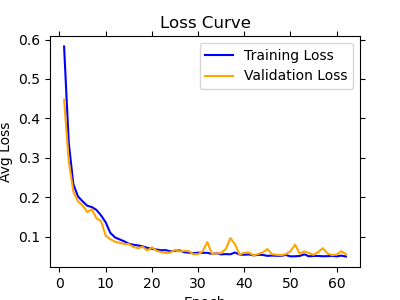

In [38]:
%matplotlib notebook

plt.ion()
f1, ax1 = plt.subplots(figsize=(4, 3))

<IPython.core.display.Javascript object>


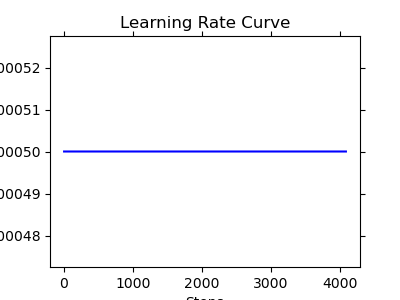

In [39]:
f2, ax2 = plt.subplots(figsize=(4, 3))

In [40]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

model2, avg_train_loss2, avg_valid_loss2, eps2, time_per_epoch2 = run_training2(epochs)

%matplotlib inline
plt.ioff()

Validation 0: 100%|█████████████████| 22/22 [00:00<00:00, 133.70it/s, loss=0.17]


Last learning rate: 0.0005
Epoch time: 2.58 s
Total time elapsed: 2.58 s
---------------------------------------
Validation loss decreased (inf --> 0.447730).  Saving model ...


Validation 1: 100%|████████████████| 22/22 [00:00<00:00, 176.34it/s, loss=0.287]


Last learning rate: 0.0005
Epoch time: 2.53 s
Total time elapsed: 5.22 s
---------------------------------------
Validation loss decreased (0.447730 --> 0.292074).  Saving model ...


Validation 2: 100%|███████████████| 22/22 [00:00<00:00, 175.39it/s, loss=0.0819]


Last learning rate: 0.0005
Epoch time: 2.57 s
Total time elapsed: 7.91 s
---------------------------------------
Validation loss decreased (0.292074 --> 0.214528).  Saving model ...


Validation 3: 100%|████████████████| 22/22 [00:00<00:00, 174.36it/s, loss=0.111]


Last learning rate: 0.0005
Epoch time: 2.42 s
Total time elapsed: 10.44 s
---------------------------------------
Validation loss decreased (0.214528 --> 0.189672).  Saving model ...


Validation 4: 100%|████████████████| 22/22 [00:00<00:00, 180.05it/s, loss=0.112]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 12.68 s
---------------------------------------
Validation loss decreased (0.189672 --> 0.179569).  Saving model ...


Validation 5: 100%|███████████████| 22/22 [00:00<00:00, 174.54it/s, loss=0.0695]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 14.92 s
---------------------------------------
Validation loss decreased (0.179569 --> 0.162307).  Saving model ...


Validation 6: 100%|████████████████| 22/22 [00:00<00:00, 177.04it/s, loss=0.295]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 17.17 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 7: 100%|████████████████| 22/22 [00:00<00:00, 171.96it/s, loss=0.127]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 19.40 s
---------------------------------------
Validation loss decreased (0.162307 --> 0.146501).  Saving model ...


Validation 8: 100%|████████████████| 22/22 [00:00<00:00, 176.24it/s, loss=0.127]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 21.64 s
---------------------------------------
Validation loss decreased (0.146501 --> 0.139532).  Saving model ...


Validation 9: 100%|████████████████| 22/22 [00:00<00:00, 157.07it/s, loss=0.073]


Last learning rate: 0.0005
Epoch time: 2.16 s
Total time elapsed: 23.91 s
---------------------------------------
Validation loss decreased (0.139532 --> 0.102068).  Saving model ...


Validation 10: 100%|██████████████| 22/22 [00:00<00:00, 172.70it/s, loss=0.0699]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 26.17 s
---------------------------------------
Validation loss decreased (0.102068 --> 0.093535).  Saving model ...


Validation 11: 100%|██████████████| 22/22 [00:00<00:00, 174.56it/s, loss=0.0605]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 28.41 s
---------------------------------------
Validation loss decreased (0.093535 --> 0.087180).  Saving model ...


Validation 12: 100%|██████████████| 22/22 [00:00<00:00, 176.49it/s, loss=0.0487]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 30.66 s
---------------------------------------
Validation loss decreased (0.087180 --> 0.084262).  Saving model ...


Validation 13: 100%|██████████████| 22/22 [00:00<00:00, 176.84it/s, loss=0.0505]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 32.91 s
---------------------------------------
Validation loss decreased (0.084262 --> 0.081439).  Saving model ...


Validation 14: 100%|██████████████| 22/22 [00:00<00:00, 177.08it/s, loss=0.0542]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 35.15 s
---------------------------------------
Validation loss decreased (0.081439 --> 0.081420).  Saving model ...


Validation 15: 100%|██████████████| 22/22 [00:00<00:00, 174.71it/s, loss=0.0685]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 37.40 s
---------------------------------------
Validation loss decreased (0.081420 --> 0.073552).  Saving model ...


Validation 16: 100%|██████████████| 22/22 [00:00<00:00, 181.68it/s, loss=0.0593]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 39.77 s
---------------------------------------
Validation loss decreased (0.073552 --> 0.070993).  Saving model ...


Validation 17: 100%|██████████████| 22/22 [00:00<00:00, 177.47it/s, loss=0.0802]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 42.02 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 18: 100%|██████████████| 22/22 [00:00<00:00, 177.80it/s, loss=0.0372]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 44.26 s
---------------------------------------
Validation loss decreased (0.070993 --> 0.064830).  Saving model ...


Validation 19: 100%|██████████████| 22/22 [00:00<00:00, 152.59it/s, loss=0.0466]


Last learning rate: 0.0005
Epoch time: 2.17 s
Total time elapsed: 46.54 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 20: 100%|███████████████| 22/22 [00:00<00:00, 149.49it/s, loss=0.059]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 48.82 s
---------------------------------------
Validation loss decreased (0.064830 --> 0.064338).  Saving model ...


Validation 21: 100%|██████████████| 22/22 [00:00<00:00, 177.97it/s, loss=0.0406]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 51.08 s
---------------------------------------
Validation loss decreased (0.064338 --> 0.060683).  Saving model ...


Validation 22: 100%|██████████████| 22/22 [00:00<00:00, 176.35it/s, loss=0.0308]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 53.35 s
---------------------------------------
Validation loss decreased (0.060683 --> 0.058664).  Saving model ...


Validation 23: 100%|██████████████| 22/22 [00:00<00:00, 179.73it/s, loss=0.0286]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 55.60 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 24: 100%|██████████████| 22/22 [00:00<00:00, 179.00it/s, loss=0.0366]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 57.84 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 25: 100%|███████████████| 22/22 [00:00<00:00, 179.75it/s, loss=0.139]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 60.07 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 26: 100%|██████████████| 22/22 [00:00<00:00, 178.48it/s, loss=0.0501]


Last learning rate: 0.0005
Epoch time: 2.16 s
Total time elapsed: 62.33 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 27: 100%|███████████████| 22/22 [00:00<00:00, 174.98it/s, loss=0.171]


Last learning rate: 0.0005
Epoch time: 2.16 s
Total time elapsed: 64.60 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 28: 100%|██████████████| 22/22 [00:00<00:00, 176.03it/s, loss=0.0282]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 66.83 s
---------------------------------------
Validation loss decreased (0.058664 --> 0.055421).  Saving model ...


Validation 29: 100%|██████████████| 22/22 [00:00<00:00, 151.75it/s, loss=0.0247]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 69.09 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 30: 100%|███████████████| 22/22 [00:00<00:00, 175.41it/s, loss=0.132]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 71.32 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 31: 100%|███████████████| 22/22 [00:00<00:00, 178.18it/s, loss=0.275]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 73.56 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 32: 100%|██████████████| 22/22 [00:00<00:00, 173.80it/s, loss=0.0319]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 75.80 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 33: 100%|██████████████| 22/22 [00:00<00:00, 181.53it/s, loss=0.0602]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 78.03 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 34: 100%|██████████████| 22/22 [00:00<00:00, 182.52it/s, loss=0.0381]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 80.25 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 35: 100%|███████████████| 22/22 [00:00<00:00, 182.03it/s, loss=0.126]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 82.47 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 36: 100%|███████████████| 22/22 [00:00<00:00, 178.71it/s, loss=0.103]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 84.71 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 37: 100%|███████████████| 22/22 [00:00<00:00, 177.42it/s, loss=0.101]


Last learning rate: 0.0005
Epoch time: 2.23 s
Total time elapsed: 87.05 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 38: 100%|███████████████| 22/22 [00:00<00:00, 185.60it/s, loss=0.047]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 89.28 s
---------------------------------------
Validation loss decreased (0.055421 --> 0.054473).  Saving model ...


Validation 39: 100%|██████████████| 22/22 [00:00<00:00, 150.33it/s, loss=0.0442]


Last learning rate: 0.0005
Epoch time: 2.15 s
Total time elapsed: 91.53 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 40: 100%|██████████████| 22/22 [00:00<00:00, 182.38it/s, loss=0.0475]


Last learning rate: 0.0005
Epoch time: 2.20 s
Total time elapsed: 93.87 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 41: 100%|██████████████| 22/22 [00:00<00:00, 182.55it/s, loss=0.0605]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 96.10 s
---------------------------------------
Validation loss decreased (0.054473 --> 0.052061).  Saving model ...


Validation 42: 100%|██████████████| 22/22 [00:00<00:00, 180.66it/s, loss=0.0712]


Last learning rate: 0.0005
Epoch time: 2.17 s
Total time elapsed: 98.39 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 43: 100%|██████████████| 22/22 [00:00<00:00, 176.32it/s, loss=0.0961]


Last learning rate: 0.0005
Epoch time: 2.11 s
Total time elapsed: 100.61 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 44: 100%|██████████████| 22/22 [00:00<00:00, 180.45it/s, loss=0.0904]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 102.85 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 45: 100%|██████████████| 22/22 [00:00<00:00, 182.31it/s, loss=0.0501]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 105.07 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 46: 100%|██████████████| 22/22 [00:00<00:00, 182.71it/s, loss=0.0607]


Last learning rate: 0.0005
Epoch time: 2.11 s
Total time elapsed: 107.29 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 47: 100%|██████████████| 22/22 [00:00<00:00, 181.16it/s, loss=0.0326]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 109.51 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 48: 100%|██████████████| 22/22 [00:00<00:00, 181.11it/s, loss=0.0569]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 111.74 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 49: 100%|██████████████| 22/22 [00:00<00:00, 182.37it/s, loss=0.0377]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 113.97 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 50: 100%|██████████████| 22/22 [00:00<00:00, 176.09it/s, loss=0.0692]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 116.21 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 51: 100%|██████████████| 22/22 [00:00<00:00, 183.58it/s, loss=0.0426]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 118.45 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 52: 100%|███████████████| 22/22 [00:00<00:00, 177.08it/s, loss=0.027]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 120.69 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 53: 100%|██████████████| 22/22 [00:00<00:00, 179.49it/s, loss=0.0636]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 122.93 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 54: 100%|███████████████| 22/22 [00:00<00:00, 182.86it/s, loss=0.024]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 125.15 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 55: 100%|███████████████| 22/22 [00:00<00:00, 180.08it/s, loss=0.108]


Last learning rate: 0.0005
Epoch time: 2.11 s
Total time elapsed: 127.36 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 56: 100%|███████████████| 22/22 [00:00<00:00, 154.46it/s, loss=0.023]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 129.60 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 57: 100%|██████████████| 22/22 [00:00<00:00, 178.38it/s, loss=0.0661]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 131.82 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 58: 100%|███████████████| 22/22 [00:00<00:00, 173.77it/s, loss=0.115]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 134.07 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 59: 100%|██████████████| 22/22 [00:00<00:00, 177.15it/s, loss=0.0554]


Last learning rate: 0.0005
Epoch time: 2.13 s
Total time elapsed: 136.41 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 60: 100%|██████████████| 22/22 [00:00<00:00, 170.81it/s, loss=0.0721]


Last learning rate: 0.0005
Epoch time: 2.14 s
Total time elapsed: 138.65 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 61: 100%|███████████████| 22/22 [00:00<00:00, 173.23it/s, loss=0.117]


Last learning rate: 0.0005
Epoch time: 2.12 s
Total time elapsed: 140.87 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


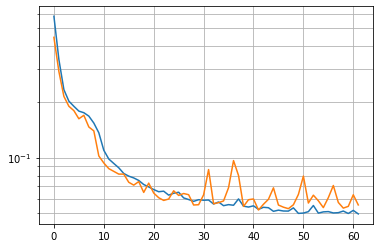

In [41]:
plt.semilogy(avg_train_loss2)
plt.semilogy(avg_valid_loss2)
plt.grid(which='both')

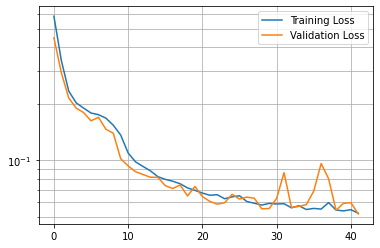

In [42]:
plt.semilogy(avg_train_loss2[:-config.patience], label='Training Loss')
plt.semilogy(avg_valid_loss2[:-config.patience], label='Validation Loss')
plt.grid(which='both')
plt.legend()

## Plot result

tensor([241,  78, 303, 173])


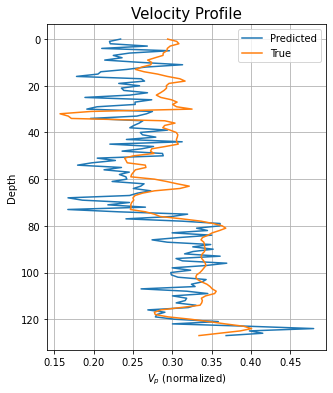

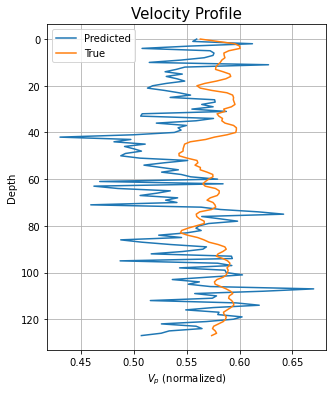

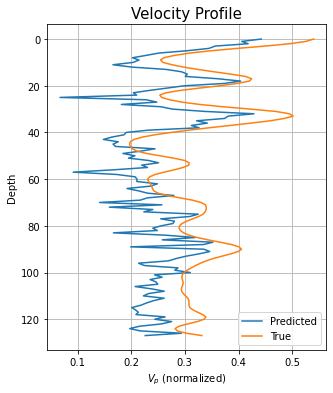

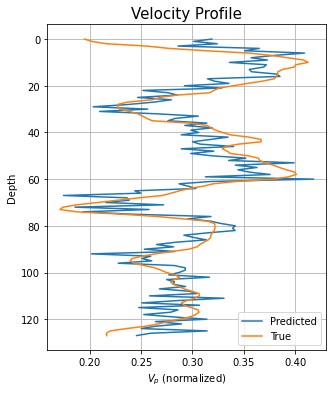

In [43]:
idx = torch.randint(high=len(valid_data2), size=(4,))
# idx = [[28]]
print(idx)
inputs_embeds = valid_data2.data['input'][idx].float()
labels = valid_data2.data['label'][idx].float()
with torch.no_grad():
    sample_output = model2(inputs_embeds=inputs_embeds.to(device))

for y, z in zip(sample_output.logits.cpu(), labels):
    f, ax = plt.subplots(1, 1, figsize=(5, 6))
    ax.plot(y, np.arange(len(y)), label="Predicted")
    ax.plot(z, np.arange(len(z)), label="True")
#     ax.plot(z-s, np.arange(len(z)), '--k', label="Std")
#     ax.plot(z+s, np.arange(len(z)), '--k')
    ax.invert_yaxis()
    ax.grid()
    ax.legend()
#     yticks2 = [0]+list(np.arange(0, 3800, 500))
#     ax.set_yticklabels(yticks2)
    ax.set_ylabel("Depth")
    ax.set_xlabel("$V_p$ (normalized)")
#     ax.set_ylabel("Depth (m)")
    ax.set_title("Velocity Profile", fontsize=15)

## Evaluate results

In [44]:
train_dataloader2 = DataLoader(train_data2, batch_size=batch_size, shuffle=False)
input_dts_train = []
pred_dts_train = []
loop_train = tqdm(train_dataloader2, leave=True)
model2.eval()

with torch.no_grad():
    for i, batch in enumerate(loop_train):
        # pull all tensor batches required for training

        # Mask outside loop
        inputs_embeds = batch['input'].float().to(device)
        labels = batch['label'].to(device)

        # process

        outputs = model2(inputs_embeds=inputs_embeds)
        
        for j in range(len(outputs.logits)):
            input_dts_train.append(inputs_embeds.squeeze(-1)[j].cpu().numpy())
            pred_dts_train.append(outputs.logits.squeeze(-1)[j].cpu().numpy())
            
input_dts_train = np.array(input_dts_train)
pred_dts_train = np.array(pred_dts_train)
weighted_score_train = r2_score(train_data2.data['label'].squeeze(), pred_dts_train, multioutput='variance_weighted')
np.save(os.path.join(config.parent_dir, "input_dts_train.npy"), input_dts_train)
np.save(os.path.join(config.parent_dir, "pred_dts_train.npy"), pred_dts_train)
print("Weighted R2 score: {}".format(weighted_score_train))

valid_dataloader2 = DataLoader(valid_data2, batch_size=batch_size, shuffle=False)
input_dts_valid = []
pred_dts_valid = []
loop_valid = tqdm(valid_dataloader2, leave=True)
model2.eval()

with torch.no_grad():
    for i, batch in enumerate(loop_valid):
        # pull all tensor batches required for training

        # Mask outside loop
        inputs_embeds = batch['input'].float().to(device)
        labels = batch['label'].to(device)

        # process

        outputs = model2(inputs_embeds=inputs_embeds)
        
        for j in range(len(outputs.logits)):
            input_dts_valid.append(inputs_embeds.squeeze(-1)[j].cpu().numpy())
            pred_dts_valid.append(outputs.logits.squeeze(-1)[j].cpu().numpy())
            
input_dts_valid = np.array(input_dts_valid)
pred_dts_valid = np.array(pred_dts_valid)
weighted_score_valid = r2_score(valid_data2.data['label'].squeeze(), pred_dts_valid, multioutput='variance_weighted')
np.save(os.path.join(config.parent_dir, "input_dts_valid.npy"), input_dts_valid)
np.save(os.path.join(config.parent_dir, "pred_dts_valid.npy"), pred_dts_valid)
print("Weighted R2 score: {}".format(weighted_score_valid))

100%|██████████████████████████████████████████| 66/66 [00:00<00:00, 317.73it/s]


Weighted R2 score: 0.9114179637649695


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 324.83it/s]

Weighted R2 score: 0.8956291066538224


In [45]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model2, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss2)
        avg_valid_loss_arr = np.array(avg_valid_loss2)
        eps_arr = np.array(eps2)
        time_arr = np.array(time_per_epoch2)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
        np.save(os.path.join(config.parent_dir, 'eps.npy'), eps_arr)
        np.save(os.path.join(config.parent_dir, 'time.npy'), time_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model2, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss2)
    avg_valid_loss_arr = np.array(avg_valid_loss2)
    eps_arr = np.array(eps2)
    time_arr = np.array(time_per_epoch2)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
    np.save(os.path.join(config.parent_dir, 'eps.npy'), eps_arr)
    np.save(os.path.join(config.parent_dir, 'time.npy'), time_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./test_run/finetune/dtspred/
Saved successfully to ./test_run/finetune/dtspred/


# Fine-tuning (Facies Prediction)

In [46]:
config.parent_dir = config.pretrain_dir
model = torch.load(os.path.join(config.parent_dir, "model.pt"))
print("Loaded model from", config.parent_dir)

Loaded model from ./test_run/pretrain/


In [47]:
# Change parent directory
config.parent_dir = os.path.join(config.finetune_dir, "faciespred/")
print(config.parent_dir)

./test_run/finetune/faciespred/


## Create fine-tuning dataset

In [48]:
# Wrap in PyTorch dataset
class WirelineDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    def __getitem__(self, idx):

        well = np.unique(self.data.WELL.values[idx*self.seq_len:(idx+1)*self.seq_len])[0]
        data = self.data.drop(columns=['FORCE_2020_LITHOFACIES_LITHOLOGY', 'DTS']).values[idx*self.seq_len:(idx+1)*self.seq_len]
        label = self.data['FORCE_2020_LITHOFACIES_LITHOLOGY'].values[idx*self.seq_len:(idx+1)*self.seq_len].reshape(-1,1)

        wells = {'well': well, 'data': data, 'label':label}

        return wells
    def __len__(self):
        return int(len(self.data)/self.seq_len)

In [49]:
train_dataloader = torch.load('../data/train_facies_dataset_128.pt')
valid_dataloader = torch.load('../data/valid_facies_dataset_128.pt')

train_X = reshape_data(train_dataloader, 128, key=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI',
                                                   'PEF', 'DTC'])
valid_X = reshape_data(valid_dataloader, 128, key=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI',
                                                   'PEF', 'DTC'])

train_X, max_val_train = norm_data(train_X)
valid_X, max_val_valid = norm_data(valid_X)

train_y = reshape_data(train_dataloader, 128, key=['FORCE_2020_LITHOFACIES_LITHOLOGY'])
valid_y = reshape_data(valid_dataloader, 128, key=['FORCE_2020_LITHOFACIES_LITHOLOGY'])


In [50]:
train_data3, valid_data3 = {}, {}

train_data3['input'], valid_data3['input'] = train_X.clone(), valid_X.clone()
train_data3['label'], valid_data3['label'] = train_y.clone(), valid_y.clone()

In [51]:
train_data3 = WirelineDataset2(train_data3)
valid_data3 = WirelineDataset2(valid_data3)

In [52]:
train_dataloader3 = DataLoader(train_data3, batch_size=batch_size, shuffle=True)
valid_dataloader3 = DataLoader(valid_data3, batch_size=batch_size, shuffle=True)

## Initialize fine-tuning model

In [53]:
class FaciesPredHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = nn.Linear(config.hidden_size, 12)
        self.act_fn = nn.Sigmoid()
        self.predictions.decoder = Identity()
        
    def forward(self, sequence_output):
        output = self.act_fn(sequence_output)
        output = self.predictions(output)
        output = output.swapaxes(1, 2)
        
        return output

In [54]:
# Replace the prediciton head of the pre-trained model
model.cls = FaciesPredHead(config)
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings3(
      (word_embeddings): Linear(in_features=9, out_features=8, bias=True)
      (position_embeddings): Embedding(128, 8)
      (LayerNorm): LayerNorm((8,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((8,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=8, out_features=8, bias=True)
              (key): Linear(in_features=8, out_features=8, bias=True)
              (value): Linear(in_features=8, out_features=8, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_features=8, out_features=8, bias=True)
              (dropout): Dropout(p=0.1, inplac

In [55]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


In [56]:
# Optimizer
if config.optim == 'adam':
    optim = torch.optim.Adam(model.parameters(), lr=config.lr)
elif config.optim == 'radam':
    optim = RAdam(model.parameters(), lr=config.lr)

# # Loss
# if config.loss_fn == 'l2':
#     loss_fn = nn.MSELoss(reduction='mean')
# elif config.loss_fn in ['l1', 'ssiml1']:
#     loss_fn = nn.L1Loss()
    
# loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()
loss_fn = nn.CrossEntropyLoss()

# Number of epochs
epochs = config.epoch

## Train

In [57]:
def run_training3(epochs):
    total_time = time.time()
    avg_train_loss = []
    avg_valid_loss = []
    eps = []
    time_per_epoch = []
    checkpoint = os.path.join(config.parent_dir, str(os.getpid())+"checkpoint.pt")
    early_stopping = EarlyStopping(patience=config.patience, verbose=True, path=checkpoint)

    for epoch in range(epochs):
        epoch_time = time.time()
        model.train()
        # setup loop with TQDM and dataloader
        loop_train = tqdm(train_dataloader3, leave=True)
        losses_train = 0
        for i, batch in enumerate(loop_train):
            # initialize calculated gradients (from prev step)
            optim.zero_grad()

            # pull all tensor batches required for training

            # Mask outside loop
            inputs_embeds = batch['input'].float().to(device)
            labels = batch['label'].squeeze().long().to(device)

            # process

            outputs = model(inputs_embeds=inputs_embeds)
            
            loss = loss_fn(outputs.logits, labels)
            
            outputs.loss = loss
            outputs.loss.backward()

            # update parameters
            optim.step()
            
            losses_train += loss.item()

            loop_train.set_description(f'Epoch {epoch}')
            loop_train.set_postfix(loss=loss.item())

            eps.append(optim.param_groups[0]["lr"])

#         model.eval()
        loop_valid = tqdm(valid_dataloader3, leave=True)
        losses_valid = 0
        with torch.no_grad():
            for i, batch in enumerate(loop_valid):
                # pull all tensor batches required for training

                # Mask outside loop
                inputs_embeds = batch['input'].float().to(device)
                labels = batch['label'].squeeze().long().to(device)

                # process

                outputs = model(inputs_embeds=inputs_embeds)
                
                loss = loss_fn(outputs.logits, labels)

                losses_valid += loss.item()

                loop_valid.set_description(f'Validation {epoch}')
                loop_valid.set_postfix(loss=loss.item())

        avg_train_loss.append(losses_train / len(train_dataloader3))
        avg_valid_loss.append(losses_valid / len(valid_dataloader3))
        print("Last learning rate: {}".format(eps[-1]))
        print("Epoch time: {:.2f} s".format(time.time() - epoch_time))
        time_per_epoch.append(time.time() - epoch_time)
        print("Total time elapsed: {:.2f} s".format(time.time() - total_time))
        print("---------------------------------------")

        ax1.cla()
        ax1.plot(np.arange(1, epoch+2), avg_train_loss,'b', label='Training Loss')
        ax1.plot(np.arange(1, epoch+2), avg_valid_loss, 'orange', label='Validation Loss')
        ax1.legend()
        ax1.set_title("Loss Curve")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Avg Loss")
        f1.canvas.draw()
        
        ax2.cla()
        ax2.plot(np.arange(1, len(train_dataloader3)*(epoch+1)+1), eps,'b')
        ax2.set_title("Learning Rate Curve")
        ax2.set_xlabel("Steps")
        ax2.set_ylabel("lr")
        f2.canvas.draw()
        
        early_stopping(avg_valid_loss[-1], model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    model.load_state_dict(torch.load(checkpoint))
    
    return model, avg_train_loss, avg_valid_loss, eps, time_per_epoch

<IPython.core.display.Javascript object>


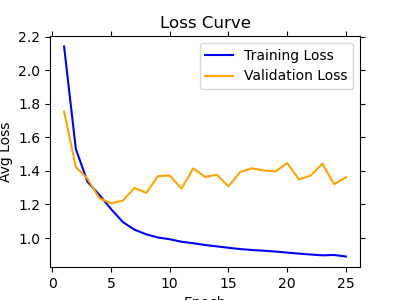

In [58]:
%matplotlib notebook

plt.ion()
f1, ax1 = plt.subplots(figsize=(4, 3))

<IPython.core.display.Javascript object>


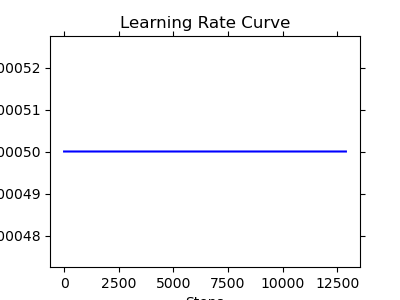

In [59]:
f2, ax2 = plt.subplots(figsize=(4, 3))

In [60]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

model3, avg_train_loss3, avg_valid_loss3, eps3, time_per_epoch3 = run_training3(epochs)

%matplotlib inline
plt.ioff()

Validation 0: 100%|█████████████████| 57/57 [00:00<00:00, 187.36it/s, loss=1.51]


Last learning rate: 0.0005
Epoch time: 16.06 s
Total time elapsed: 16.06 s
---------------------------------------
Validation loss decreased (inf --> 1.753545).  Saving model ...


Validation 1: 100%|█████████████████| 57/57 [00:00<00:00, 181.06it/s, loss=1.14]


Last learning rate: 0.0005
Epoch time: 16.11 s
Total time elapsed: 32.29 s
---------------------------------------
Validation loss decreased (1.753545 --> 1.422750).  Saving model ...


Validation 2: 100%|█████████████████| 57/57 [00:00<00:00, 185.39it/s, loss=2.23]


Last learning rate: 0.0005
Epoch time: 16.14 s
Total time elapsed: 48.54 s
---------------------------------------
Validation loss decreased (1.422750 --> 1.353331).  Saving model ...


Validation 3: 100%|████████████████| 57/57 [00:00<00:00, 181.61it/s, loss=0.779]


Last learning rate: 0.0005
Epoch time: 16.10 s
Total time elapsed: 64.76 s
---------------------------------------
Validation loss decreased (1.353331 --> 1.236911).  Saving model ...


Validation 4: 100%|█████████████████| 57/57 [00:00<00:00, 186.32it/s, loss=1.16]


Last learning rate: 0.0005
Epoch time: 16.05 s
Total time elapsed: 80.92 s
---------------------------------------
Validation loss decreased (1.236911 --> 1.207240).  Saving model ...


Validation 5: 100%|█████████████████| 57/57 [00:00<00:00, 165.73it/s, loss=1.05]


Last learning rate: 0.0005
Epoch time: 16.06 s
Total time elapsed: 97.10 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 6: 100%|█████████████████| 57/57 [00:00<00:00, 182.12it/s, loss=2.31]


Last learning rate: 0.0005
Epoch time: 16.09 s
Total time elapsed: 113.42 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 7: 100%|██████████████████| 57/57 [00:00<00:00, 186.01it/s, loss=1.4]


Last learning rate: 0.0005
Epoch time: 16.06 s
Total time elapsed: 129.60 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 8: 100%|█████████████████| 57/57 [00:00<00:00, 185.09it/s, loss=1.78]


Last learning rate: 0.0005
Epoch time: 16.09 s
Total time elapsed: 145.80 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 9: 100%|██████████████████| 57/57 [00:00<00:00, 184.97it/s, loss=1.6]


Last learning rate: 0.0005
Epoch time: 16.14 s
Total time elapsed: 162.04 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 10: 100%|████████████████| 57/57 [00:00<00:00, 187.06it/s, loss=1.75]


Last learning rate: 0.0005
Epoch time: 17.22 s
Total time elapsed: 179.37 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 11: 100%|████████████████| 57/57 [00:00<00:00, 178.26it/s, loss=1.57]


Last learning rate: 0.0005
Epoch time: 16.05 s
Total time elapsed: 195.53 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 12: 100%|█████████████████| 57/57 [00:00<00:00, 183.68it/s, loss=1.6]


Last learning rate: 0.0005
Epoch time: 16.07 s
Total time elapsed: 211.71 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 13: 100%|████████████████| 57/57 [00:00<00:00, 187.58it/s, loss=1.19]


Last learning rate: 0.0005
Epoch time: 16.06 s
Total time elapsed: 227.87 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 14: 100%|███████████████| 57/57 [00:00<00:00, 184.65it/s, loss=0.716]


Last learning rate: 0.0005
Epoch time: 16.08 s
Total time elapsed: 244.06 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 15: 100%|████████████████| 57/57 [00:00<00:00, 187.14it/s, loss=1.74]


Last learning rate: 0.0005
Epoch time: 16.16 s
Total time elapsed: 260.32 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 16: 100%|████████████████| 57/57 [00:00<00:00, 183.94it/s, loss=1.04]


Last learning rate: 0.0005
Epoch time: 16.06 s
Total time elapsed: 276.49 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 17: 100%|███████████████| 57/57 [00:00<00:00, 188.35it/s, loss=0.891]


Last learning rate: 0.0005
Epoch time: 16.09 s
Total time elapsed: 292.69 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 18: 100%|████████████████| 57/57 [00:00<00:00, 188.27it/s, loss=2.47]


Last learning rate: 0.0005
Epoch time: 16.14 s
Total time elapsed: 308.94 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 19: 100%|████████████████| 57/57 [00:00<00:00, 184.61it/s, loss=1.56]


Last learning rate: 0.0005
Epoch time: 17.97 s
Total time elapsed: 327.02 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 20: 100%|███████████████| 57/57 [00:00<00:00, 184.02it/s, loss=0.325]


Last learning rate: 0.0005
Epoch time: 16.14 s
Total time elapsed: 343.27 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 21: 100%|████████████████| 57/57 [00:00<00:00, 187.05it/s, loss=1.57]


Last learning rate: 0.0005
Epoch time: 16.12 s
Total time elapsed: 359.50 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 22: 100%|████████████████| 57/57 [00:00<00:00, 183.71it/s, loss=1.81]


Last learning rate: 0.0005
Epoch time: 16.09 s
Total time elapsed: 375.71 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 23: 100%|███████████████| 57/57 [00:00<00:00, 176.52it/s, loss=0.476]


Last learning rate: 0.0005
Epoch time: 16.07 s
Total time elapsed: 391.90 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 24: 100%|████████████████| 57/57 [00:00<00:00, 180.99it/s, loss=1.94]


Last learning rate: 0.0005
Epoch time: 16.12 s
Total time elapsed: 408.15 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


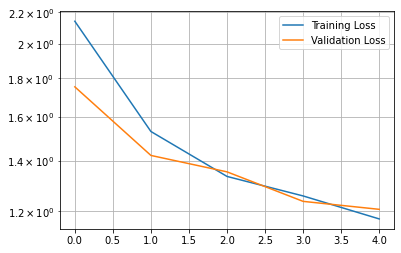

In [61]:
plt.semilogy(avg_train_loss3[:-config.patience], label='Training Loss')
plt.semilogy(avg_valid_loss3[:-config.patience], label='Validation Loss')
plt.grid(which='both')
plt.legend()

## Evaluate results

100%|████████████████████████████████████████| 516/516 [00:01<00:00, 291.64it/s]


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='True Facies', ylabel='Predicted Facies'>)

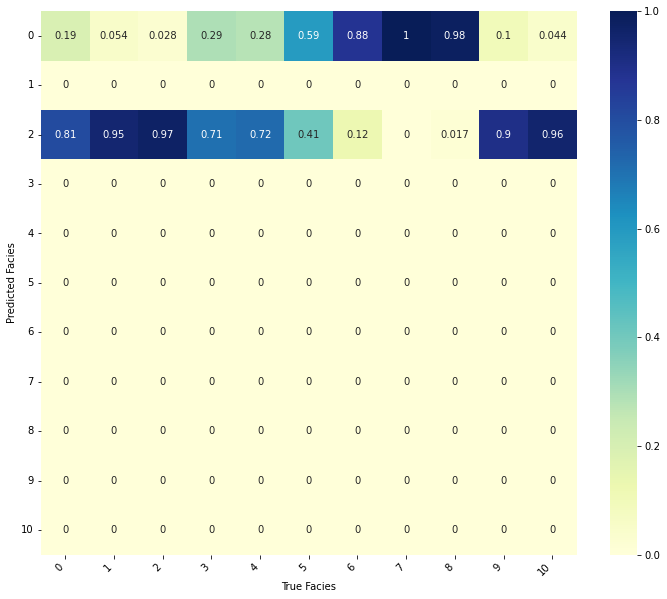

In [62]:
train_dataloader3 = DataLoader(train_data3, batch_size=batch_size, shuffle=False)
input_facies_train = []
pred_facies_train = []
loop_train = tqdm(train_dataloader3, leave=True)
model3.eval()

with torch.no_grad():
    for i, batch in enumerate(loop_train):
        # pull all tensor batches required for training

        # Mask outside loop
        inputs_embeds = batch['input'].float().to(device)
        labels = batch['label'].to(device)

        # process

        outputs = model3(inputs_embeds=inputs_embeds)
        
        for j in range(len(outputs.logits)):
            input_facies_train.append(inputs_embeds.squeeze(-1)[j].cpu().numpy())
            pred_facies_train.append(torch.argmax(outputs.logits.squeeze(-1)[j], dim=0).cpu().numpy())
            
input_facies_train = np.array(input_facies_train)
pred_facies_train = np.array(pred_facies_train)
np.save(os.path.join(config.parent_dir, "input_facies_train.npy"), input_facies_train)
np.save(os.path.join(config.parent_dir, "pred_facies_train.npy"), pred_facies_train)
confusion_matrix_facies(pred_facies_train.flatten(), train_data3.data['label'].flatten(),
                       facies_labels=np.arange(0, 11))

100%|██████████████████████████████████████████| 57/57 [00:00<00:00, 261.63it/s]


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='True Facies', ylabel='Predicted Facies'>)

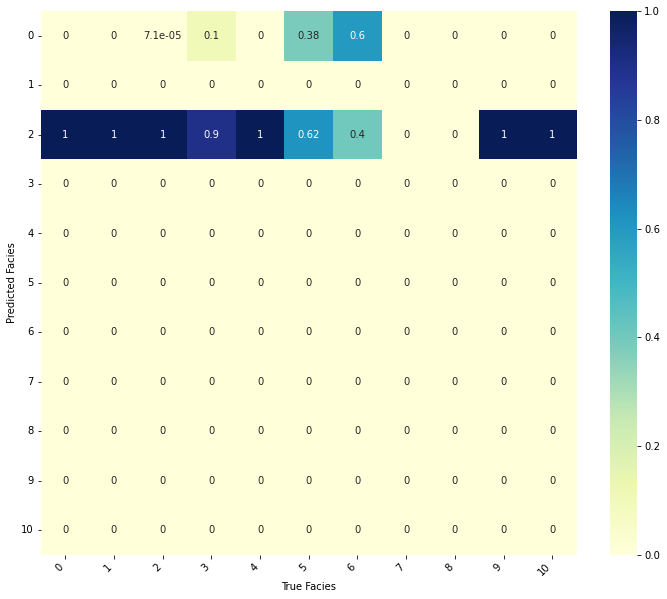

In [65]:
valid_dataloader3 = DataLoader(valid_data3, batch_size=batch_size, shuffle=False)
input_facies_valid = []
pred_facies_valid = []
loop_valid = tqdm(valid_dataloader3, leave=True)
model3.eval()

with torch.no_grad():
    for i, batch in enumerate(loop_valid):
        # pull all tensor batches required for training

        # Mask outside loop
        inputs_embeds = batch['input'].float().to(device)
        labels = batch['label'].to(device)

        # process

        outputs = model3(inputs_embeds=inputs_embeds)
        
        for j in range(len(outputs.logits)):
            input_facies_valid.append(inputs_embeds.squeeze(-1)[j].cpu().numpy())
            pred_facies_valid.append(torch.argmax(outputs.logits.squeeze(-1)[j], dim=0).cpu().numpy())
            
input_facies_valid = np.array(input_facies_valid)
pred_facies_valid = np.array(pred_facies_valid)
np.save(os.path.join(config.parent_dir, "input_facies_valid.npy"), input_facies_valid)
np.save(os.path.join(config.parent_dir, "pred_facies_valid.npy"), pred_facies_valid)
confusion_matrix_facies(pred_facies_valid.flatten(), valid_data3.data['label'].flatten(),
                       facies_labels=np.arange(0, 11))

In [64]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model3, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss3)
        avg_valid_loss_arr = np.array(avg_valid_loss3)
        eps_arr = np.array(eps3)
        time_arr = np.array(time_per_epoch3)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
        np.save(os.path.join(config.parent_dir, 'eps.npy'), eps_arr)
        np.save(os.path.join(config.parent_dir, 'time.npy'), time_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model3, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss3)
    avg_valid_loss_arr = np.array(avg_valid_loss3)
    eps_arr = np.array(eps3)
    time_arr = np.array(time_per_epoch3)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
    np.save(os.path.join(config.parent_dir, 'eps.npy'), eps_arr)
    np.save(os.path.join(config.parent_dir, 'time.npy'), time_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./test_run/finetune/faciespred/
Saved successfully to ./test_run/finetune/faciespred/
